# model_training_o2mnist
This notebook is an example of loading data and building a model from a config file. It shows how a model is trained using similar code to `run.py`. There is no automatic logging. 


To train a model without a notebook, check the repo's README.

In [1]:
import sys
sys.path.append("../")
import importlib
import train_loops
import run
import torch
from utils import utils
import wandb
import logging
import os 
from pathlib import Path
from configs.config_o2mnist import config

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load dataset and view sample data 
*** First you need to build the o2-vae datset: Navigate to `data/` and run `python generate_o2mnist.py`.  

sample train data


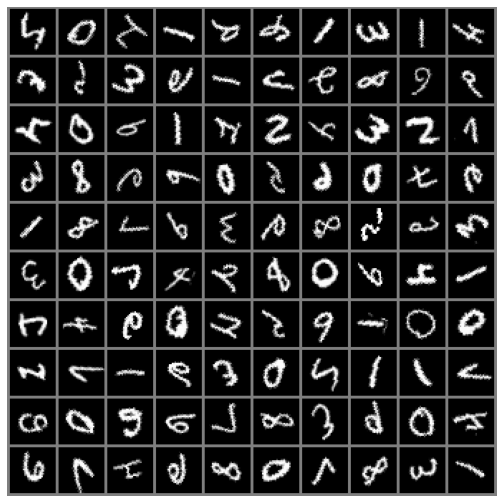

In [2]:
importlib.reload(utils)
# get datasets specified by config.data
dset, loader, dset_test, loader_test = run.get_datasets_from_config(config)
print("sample train data")
f, axs = utils.plot_sample_data(loader)
f

## Load the model from config parameters

In [3]:
config.model.encoder.n_channels=dset[0][0].shape[0]  # image channels
model = run.build_model_from_config(config)

# optimizer - by default, no lr scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=config.optimizer.lr)

print(model.model_details())

Encoder type <class 'models.encoders_o2.e2scnn.E2SFCNN'>
Decoder type <class 'models.decoders.cnn_decoder.CnnDecoder'>
Bottleneck dims 256
Loss func: bce, beta=0.01 loss aligns output: True 
Parameter counts: 
 encoder 194,464
 decoder 326,401
 total   520,865


## Model training
To load a pretrained model for O2-mnist, set `TRAIN_MODEL=True` in the next cell (which will only work if the model config ia still the default
Set that 

In [8]:

try: 
    for epoch in range(config.run.epochs):
        train_loops.train(epoch, model, loader, optimizer, do_progress_bar=config.logging.do_progress_bar,
               do_wandb=0, device=device)

        if config.run.do_validation and epoch%config.run.valid_freq==0:
            train_loops.valid(epoch, model, loader_test, do_progress_bar=config.logging.do_progress_bar,
                    do_wandb=0, device=device)
except KeyboardInterrupt: 
    print("Keyboard interrupt")


Train epoch 0 | loss: 192.93; recon: 192.1; kl : 82.926; beta 0.01: 100%|██████████| 235/235 [01:00<00:00,  3.87it/s] 
**** Test epoch 0 | loss: 161.86; recon: 160.87; kl : 99.083; beta 0.01: 100%|██████████| 40/40 [00:05<00:00,  7.99it/s]
Train epoch 1 | loss: 156.95; recon: 155.77; kl : 118.69; beta 0.01: 100%|██████████| 235/235 [00:58<00:00,  4.03it/s]
Train epoch 2 | loss: 146.9; recon: 145.51; kl : 139; beta 0.01: 100%|██████████| 235/235 [00:57<00:00,  4.06it/s]    
Train epoch 3 | loss: 139.11; recon: 137.53; kl : 157.96; beta 0.01: 100%|██████████| 235/235 [00:58<00:00,  3.99it/s]
Train epoch 4 | loss: 133.67; recon: 131.96; kl : 170.76; beta 0.01: 100%|██████████| 235/235 [01:01<00:00,  3.85it/s]
Train epoch 5 | loss: 130.64; recon: 128.87; kl : 177.29; beta 0.01: 100%|██████████| 235/235 [00:59<00:00,  3.92it/s]
Train epoch 6 | loss: 128.34; recon: 126.54; kl : 180.06; beta 0.01: 100%|██████████| 235/235 [01:00<00:00,  3.87it/s]
Train epoch 7 | loss: 126.53; recon: 124.72; k

Keyboard interrupt


## Save a model

In [ ]:
fname_model=None
if fname_model:
    model.train()
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),}, fname)

## Some sanity checks
#### Reconstruction quality and the 

Left: reconstructions.
Right: reconstructions where output is re-algined


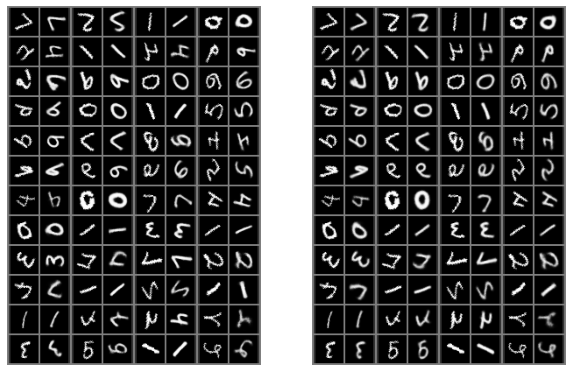

In [67]:
from utils import eval_utils
import matplotlib.pyplot as plt
importlib.reload(eval_utils)
model.eval().cpu() 

x,y = next(iter(loader_test))
reconstruct_grid = eval_utils.reconstruction_grid(model, x, align=False)
reconstruct_grid_aligned = eval_utils.reconstruction_grid(model, x, align=True)
f,axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(reconstruct_grid)
axs[1].imshow(reconstruct_grid_aligned)
print("Left: reconstructions.")
print("Right: reconstructions where output is re-algined")
axs[0].set_axis_off();  axs[1].set_axis_off()

## Extract features to an array

In [ ]:
device='cuda'
embeddings, labels = utils.get_model_embeddings_from_loader(model, loader, return_labels=True)
embeddings_test, labels_test = utils.get_model_embeddings_from_loader(model, loader_test, return_labels=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.35it/s]


In [16]:
x,_=next(iter(loader))
y = x.clone()
from registration import registration

# object for doing polar coordinate transform
PolarTransform = registration.PolarTranformBatch(image_shape=x.shape[-2:])
# map to polar coordinates, x, y, and a flipped version of y
x_polar, y_polar = PolarTransform.warp_batch(x), PolarTransform.warp_batch(y)

# recover the best rotations using polar coordinates
shifts_r, error_r, phasediff_r = registration.phase_correlation_2d_batch(x_polar, y_polar)
angle_r = -shifts_r[:,0]


In [17]:
shifts_r

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0